# Loading Libraries

In [2]:
import pandas as pd
import sqlite3
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.naive_bayes import  GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import nltk
import warnings 
import time
warnings.filterwarnings('ignore')
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from sklearn.metrics import f1_score, roc_auc_score, log_loss
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder

**Import data from database**

In [3]:
con = sqlite3.connect("database.sqlite")
df = pd.read_sql_query("SELECT * from Reviews", con)
display(df.head())
con.close()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Convert using Columns into DataFrame**

In [4]:
df = df[['Text', 'Score']]
df.head(10)

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
5,I got a wild hair for taffy and ordered this f...,4
6,This saltwater taffy had great flavors and was...,5
7,This taffy is so good. It is very soft and ch...,5
8,Right now I'm mostly just sprouting this so my...,5
9,This is a very healthy dog food. Good for thei...,5


In [5]:
# Convert Score into postive and negative through function
def f(x):
    if x >3:
        return "positive"
    else:
        return "negative"
df['Score']=df.Score.apply(f)
df

,Text,Score
0,I have bought several of the Vitality canned d...,positive
1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,This is a confection that has been around a fe...,positive
3,If you are looking for the secret ingredient i...,negative
4,Great taffy at a great price. There was a wid...,positive
...,...,...
568449,Great for sesame chicken..this is a good if no...,positive
568450,I'm disappointed with the flavor. The chocolat...,negative
568451,"These stars are small, so you can give 10-15 o...",positive
568452,These are the BEST treats for training and rew...,positive


**preprocessing Text Data**

In [6]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [7]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['Text']=df['Text'].apply(denoise_text)

In [8]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
df['Text'] = df['Text'].apply(remove_special_characters)

In [9]:
stop=set(stopwords.words('english'))
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['Score']=df['Score'].apply(remove_stopwords)

In [10]:
# Convert data into traning and testing part
x=df.iloc[:,0]
y=df.iloc[:,1]
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.3,random_state=0)

In [11]:
# Apply CountVectorizer to convert Text data into numbers 
vectorizer = CountVectorizer(max_features=50)
x_train=vectorizer.fit_transform(x_train).toarray()
x_test=vectorizer.transform(x_test).toarray()
print(x_train.shape)
print(x_test.shape)

(397917, 50)
(170537, 50)


**Apply Machine Learning Models**

In [11]:
#Function For Sentiment Scores
def calculate_sentiment_scores(sentence):
    sntmnt = analyzer.polarity_scores(sentence)['compound']
    return(sntmnt)

In [17]:
CF_RFC=confusion_matrix(y_test,y_pred)
print(CF_RFC)
CR_RFC=classification_report(y_test,y_pred)
print(CR_RFC)

[[ 10601  26837]
 [ 19265 113834]]
              precision    recall  f1-score   support

    negative       0.35      0.28      0.32     37438
    positive       0.81      0.86      0.83    133099

    accuracy                           0.73    170537
   macro avg       0.58      0.57      0.57    170537
weighted avg       0.71      0.73      0.72    170537



**Confussion Matrix And Classification Report Of Gaussian Naive-Bayes**

In [13]:
CF=confusion_matrix(y_test,y_pred)
print(CF)
CR=classification_report(y_test,y_pred)
print(CR)

[[ 10601  26837]
 [ 19265 113834]]
              precision    recall  f1-score   support

    negative       0.35      0.28      0.32     37438
    positive       0.81      0.86      0.83    133099

    accuracy                           0.73    170537
   macro avg       0.58      0.57      0.57    170537
weighted avg       0.71      0.73      0.72    170537



[Text(0.5, 1.0, 'Confusion Matrix OF GB')]

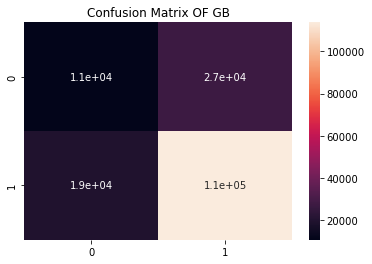

In [14]:
# Confusion Matrix Graph of GB
sns.heatmap(CF, annot=True).set(title='Confusion Matrix OF GB')

In [15]:
# Random Forest Classifier

In [16]:
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
y_pred_rf=clf.predict(x_test)
accucarcy_RFC=accuracy_score(y_test,y_pred)
print("Accuracy score: ", accucarcy_RFC)

Accuracy score:  0.7296657030439142


**Confussion Matrix And Classification Report Of RandomForestClassifier**

**Lexcion-Based Sentiment with Vader**

In [10]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
#Calculate Sentiment Score
start = time.time()

eng_snt_score =  []

for comment in df.Text.to_list():
    snts_score = calculate_sentiment_scores(comment)
    eng_snt_score.append(snts_score)
    
end = time.time()

In [ ]:
#Add Sentiment Score into DataFrame
df['sentiment_score'] = np.array(eng_snt_score)
df.head()

In [185]:
#Fount Sentiment_Score labels into postive and Negative
i = 0

vader_sentiment = [ ]

while(i<len(df)):
    if ((df.iloc[i]['sentiment_score'] >= 0.05)):
        vader_sentiment.append('positive')
        i = i+1

    else:
        vader_sentiment.append('negative')
        i = i+1

In [186]:
#Add label into DataFrame
df['vader_sentiment_labels'] = vader_sentiment

In [190]:
#Add to new column in DataFrame 
df['actual_label'] = df['Score'].map({'positive': 1, 'negative':-1})
df['predicted_label'] = df['vader_sentiment_labels'].map({'positive': 1, 'negative':-1})

df.head()

,Text,Score,sentiment_score,vader_sentiment_labels,actual_label,predicted_label
0,I have bought several of the Vitality canned d...,positive,0.9441,positive,1,1
1,Product arrived labeled as Jumbo Salted Peanut...,negative,-0.5664,negative,-1,-1
2,This is a confection that has been around a fe...,positive,0.8138,positive,1,1
3,If you are looking for the secret ingredient i...,negative,0.4404,positive,-1,1
4,Great taffy at a great price There was a wide...,positive,0.9468,positive,1,1


In [191]:
y_act = df['actual_label'].values
y_pred = df['predicted_label'].values

In [ ]:
# Accuracy Score

In [210]:
acc_lb=accuracy_score(y_act, y_pred)
print("Accuracy score:", acc_lb)

0.8216724660218769


**Confussion Matrix And Classification Report Of Lexcion-Based Sentiment with Vader**

In [155]:
CF_LB=confusion_matrix(y_act,y_pred)
print(CF_LB)
CR_LB=classification_report(y_act,y_pred)
print(CR_LB)

[[ 46539  78138]
 [ 23233 420544]]
              precision    recall  f1-score   support

          -1       0.67      0.37      0.48    124677
           1       0.84      0.95      0.89    443777

    accuracy                           0.82    568454
   macro avg       0.76      0.66      0.69    568454
weighted avg       0.80      0.82      0.80    568454



[Text(0.5, 1.0, 'Confusion Matrix OF LB')]

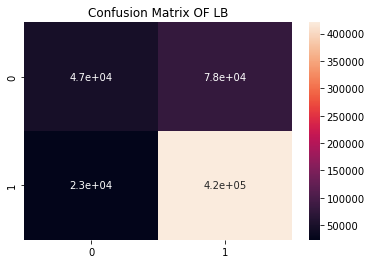

In [88]:
#Graph of Confusion Matrix of LB
sns.heatmap(CF_LB, annot=True).set(title='Confusion Matrix OF LB')

**Artifical Neural Network**

In [205]:
#Train test splition for ANN
x=df.iloc[:,0]
y=df.iloc[:,1]
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

In [206]:
#Apply CountVectorizer on ANN training data

In [207]:
vectorizer = CountVectorizer(max_features=50)
X_train=vectorizer.fit_transform(X_train).toarray()
X_test=vectorizer.transform(X_test).toarray()
print(X_train)
print(X_test)

[[1 0 0 ... 0 0 0]
 [0 2 3 ... 0 0 1]
 [1 3 1 ... 0 0 0]
 ...
 [1 2 1 ... 0 2 2]
 [0 3 2 ... 1 0 7]
 [0 0 0 ... 0 1 0]]
[[0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 3 0 ... 1 2 0]
 ...
 [0 2 2 ... 0 0 2]
 [0 0 0 ... 0 0 0]
 [0 3 0 ... 1 0 0]]


In [198]:
#reshape data from 3-D to 2-D array
X_train = X_train.reshape(397917, 50)
X_test = X_test.reshape(170537, 50)

In [208]:
#apply label Encoder For testing
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [209]:
#initializing ANN model
classifier_e25 = Sequential()
#add 1st hidden layer
classifier_e25.add(Dense(input_dim = X_train.shape[1], units = 128, kernel_initializer='uniform', activation='relu'))
#add output layer
classifier_e25.add(Dense(units = 2, kernel_initializer='uniform', activation='softmax'))
#compile the neural network
classifier_e25.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
#model summary
classifier_e25.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 128)               6528      
                                                                 
 dense_42 (Dense)            (None, 2)                 258       
                                                                 
Total params: 6,786
Trainable params: 6,786
Non-trainable params: 0
_________________________________________________________________


In [138]:
#fit training dataset into the model
classifier_e25_fit = classifier_e25.fit(X_train, to_categorical(y_train), epochs=10)

Epoch 1/10
12435/12435 [==============================] - 21s 2ms/step - loss: 0.4331 - accuracy: 0.8017
Epoch 2/10
12435/12435 [==============================] - 20s 2ms/step - loss: 0.4220 - accuracy: 0.8066
Epoch 3/10
12435/12435 [==============================] - 20s 2ms/step - loss: 0.4170 - accuracy: 0.8087
Epoch 4/10
12435/12435 [==============================] - 22s 2ms/step - loss: 0.4131 - accuracy: 0.8106
Epoch 5/10
12435/12435 [==============================] - 20s 2ms/step - loss: 0.4103 - accuracy: 0.8123
Epoch 6/10
12435/12435 [==============================] - 20s 2ms/step - loss: 0.4080 - accuracy: 0.8139
Epoch 7/10
12435/12435 [==============================] - 20s 2ms/step - loss: 0.4058 - accuracy: 0.8153
Epoch 8/10
12435/12435 [==============================] - 20s 2ms/step - loss: 0.4045 - accuracy: 0.8163
Epoch 9/10
12435/12435 [==============================] - 20s 2ms/step - loss: 0.4031 - accuracy: 0.8169
Epoch 10/10
12435/12435 [==============================

In [139]:
#evaluate the model for testing dataset
test_loss_e25 = classifier_e25.evaluate(X_test, to_categorical(y_test))

5330/5330 [==============================] - 8s 1ms/step - loss: 0.4121 - accuracy: 0.8124


In [140]:
#Predict test accuracy
output_test = classifier_e25.predict(X_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

test auc: 0.8119319660564459


In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,output_test)
print('Accuracy of ANN: %f' % accuracy)

**Accuracy Camparsion Comparison Between GuassinNB,RandomForestClassifier,Lexicon-Based And ArtificalNeuralNetwork**

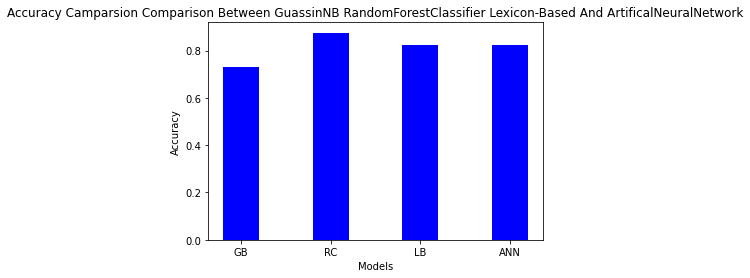

In [213]:
data = {'GB': acc, 'RC': accucarcy_RFC,'LB':acc_lb,'ANN':accuracy}
names = list(data.keys())
values = list(data.values())
plt.bar(range(len(data)), values, tick_label=names,color ='Blue',width = 0.4)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title("Accuracy Camparsion Comparison Between GuassinNB RandomForestClassifier Lexicon-Based And ArtificalNeuralNetwork")
plt.show()